In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import random

shap.initjs()

In [2]:
# ============================
# 1. Load cleaned data
# ============================

data_path = "./data/processed/financial_report_bank_zscore_clean.csv"
df = pd.read_csv(data_path)

print("Shape data:", df.shape)
print(df.head())
df.head()

Shape data: (1812, 27)
  symbol  calendar_year period    time       size       der       dar  \
0   AGRO           2023     Q4  2023Q4  30.151990  0.158755  0.043646   
1   AGRO           2023     Q3  2023Q3  30.067564  0.027119  0.008067   
2   AGRO           2023     Q2  2023Q2  30.116618  0.033987  0.009662   
3   AGRO           2023     Q1  2023Q1  30.168138  0.033731  0.009062   
4   AGRO           2022     Q4  2022Q4  30.262822  0.032612  0.007952   

        roa       roe      sdoa  ...  operating_income_ratio  quarter  \
0  0.000778  0.002830  0.000161  ...               -0.070020        4   
1  0.000472  0.001587  0.000052  ...                0.109110        3   
2  0.000408  0.001436  0.000891  ...                0.748114        2   
3  0.000346  0.001287  0.001173  ...                0.859516        1   
4 -0.001512 -0.006200  0.001532  ...                0.531961        4   

   equity_to_assets  roa_std_bank  bank_zscore  roa_count_bank  mask_bad  \
0          0.956354    

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,operating_income_ratio,quarter,equity_to_assets,roa_std_bank,bank_zscore,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk
0,AGRO,2023,Q4,2023Q4,30.151990,0.158755,0.043646,0.000778,0.002830,0.000161,...,-0.070020,4,0.956354,0.018465,51.835988,40,False,51.835988,2.0,1
1,AGRO,2023,Q3,2023Q3,30.067564,0.027119,0.008067,0.000472,0.001587,0.000052,...,0.109110,3,0.991933,0.018465,53.746257,40,False,53.746257,2.0,1
2,AGRO,2023,Q2,2023Q2,30.116618,0.033987,0.009662,0.000408,0.001436,0.000891,...,0.748114,2,0.990338,0.018465,53.656465,40,False,53.656465,2.0,1
3,AGRO,2023,Q1,2023Q1,30.168138,0.033731,0.009062,0.000346,0.001287,0.001173,...,0.859516,1,0.990938,0.018465,53.685576,40,False,53.685576,2.0,1
4,AGRO,2022,Q4,2022Q4,30.262822,0.032612,0.007952,-0.001512,-0.006200,0.001532,...,0.531961,4,0.992048,0.018465,53.645055,40,False,53.645055,2.0,1


In [3]:
# ============================
# 2. Filter data tahun (tidak pakai 2024 yang incomplete)
# ============================
YEAR_START = 2014
YEAR_END   = 2023

df = df[df["calendar_year"].between(YEAR_START, YEAR_END)].copy()

# Kalau df kamu sudah yearly (1 row per bank-year), bagian ini boleh di-skip
if "symbol" in df.columns and "period" in df.columns:
    ok_pairs = (
        df.groupby(["symbol", "calendar_year"])["period"]
          .nunique()
          .reset_index(name="n_quarters")
          .query("n_quarters == 4")[["symbol", "calendar_year"]]
    )
    df = df.merge(ok_pairs, on=["symbol", "calendar_year"], how="inner")

# ============================
# 3. Pilih fitur & target
# ============================

feature_cols = [
    "size",
    "der", "dar",
    "roa", "roe",
    "sdoa", "sdroe",
    "tobinq",
    "ppe",
    "cash",
    "ar",
    "log_sales",
    "sgr",
    "operating_income_ratio",
    "equity_to_assets"
]

target_col = "bank_zscore_risk"

# Buang baris yang ada NaN di fitur/target
df_model = df.dropna(subset=feature_cols + [target_col]).copy()

X = df_model[feature_cols]
y = df_model[target_col].astype(int)

print("Data used years:", df_model["calendar_year"].min(), "-", df_model["calendar_year"].max())
print("Total rows:", len(df_model), "| Positive rate:", round(y.mean(), 4))

Data used years: 2014 - 2023
Total rows: 1812 | Positive rate: 0.2445


In [4]:
# Label per Horizon

MAX_HORIZON = 5

df_h = df_model.sort_values(["symbol", "calendar_year"]).copy()

for h in range(1, MAX_HORIZON + 1):
    df_h[f"distress_{h}y"] = (
        df_h.groupby("symbol")["bank_zscore_risk"]
            .shift(-h)
    )

df_h.head()

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk,distress_1y,distress_2y,distress_3y,distress_4y,distress_5y
36,AGRO,2014,Q4,2014Q4,29.485003,0.163192,0.035647,0.003419,0.024146,0.000710,...,40,False,52.412198,2.0,1,1.0,1.0,1.0,1.0,1.0
37,AGRO,2014,Q3,2014Q3,29.414072,0.163192,0.035647,0.001679,0.011505,0.000584,...,40,False,52.318001,2.0,1,1.0,1.0,1.0,1.0,1.0
38,AGRO,2014,Q2,2014Q2,29.370668,0.163192,0.035647,0.002572,0.017084,0.001346,...,40,False,52.366372,2.0,1,1.0,1.0,1.0,1.0,1.0
39,AGRO,2014,Q1,2014Q1,29.276297,0.163192,0.035647,0.003093,0.018537,0.002200,...,40,False,52.394569,2.0,1,1.0,1.0,1.0,1.0,1.0
32,AGRO,2015,Q4,2015Q4,29.755018,0.163192,0.035647,0.003282,0.020299,0.000690,...,40,False,52.404806,2.0,1,1.0,1.0,1.0,1.0,1.0


In [9]:
# ============================
# RANDOM FOREST FUNCTIONS
# ============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score,
    average_precision_score,
    precision_recall_curve
)

TRAIN_END_YEAR = 2019
VAL_END_YEAR = 2021


def build_threshold_table(y_true, proba):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)

    rows = []
    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()

        rows.append({
            "threshold": thr,
            "recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan,
            "precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan,
            "type_i_error": fn / (fn + tp) if (fn + tp) > 0 else np.nan,
            "type_ii_error": fp / (fp + tn) if (fp + tn) > 0 else np.nan,
        })

    return pd.DataFrame(rows)


def choose_threshold_max_type1(
    y_true,
    proba,
    max_type1=0.25
):
    thr_df = build_threshold_table(y_true, proba)

    feasible = thr_df[thr_df["type_i_error"] <= max_type1]

    if feasible.empty:
        print("No threshold satisfies Type I constraint")
        return None

    # pilih threshold PALING BESAR (paling konservatif)
    best_row = feasible.sort_values("threshold", ascending=False).iloc[0]

    return best_row["threshold"], best_row


def train_rf_for_horizon(
    df,
    feature_cols,
    horizon,
    train_end_year,
    val_end_year,
    recall_target=0.75,
    rf_params=None
):
    print(f"\n===== TRAIN RF HORIZON {horizon}Y =====")

    # ============================
    # Prepare data
    # ============================
    df_hh = df.dropna(subset=[f"distress_{horizon}y"]).copy()

    y = df_hh[f"distress_{horizon}y"].astype(int)
    X = df_hh[feature_cols]

    # time-based split
    train_mask = df_hh["calendar_year"] <= train_end_year
    val_mask   = (df_hh["calendar_year"] > train_end_year) & \
                 (df_hh["calendar_year"] <= val_end_year)
    test_mask  = df_hh["calendar_year"] > val_end_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    # ============================
    # Handle imbalance
    # ============================
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    class_weight = {
        0: 1.0,
        1: neg / pos
    }

    # default RF params (aman & stabil)
    if rf_params is None:
        rf_params = {
            "n_estimators": 1000,
            "max_depth": 8,
            "min_samples_leaf": 15,
            "min_samples_split": 30,
            "max_features": "sqrt",
            "class_weight": class_weight,
            "random_state": 42,
            "n_jobs": -1
        }

    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)

    # ============================
    # Threshold tuning (VAL)
    # ============================
    proba_val = rf.predict_proba(X_val)[:, 1]

    # thr_df = build_threshold_table(y_val, proba_val)
    # chosen_thr = thr_df[thr_df["recall"] >= recall_target].iloc[-1]["threshold"]

    chosen_thr, row = choose_threshold_max_type1(y_val, proba_val, max_type1=0.25)

    print("Chosen threshold:", round(chosen_thr, 4))

    return {
        "model_type": "random_forest",
        "horizon": horizon,
        "model": rf,
        "threshold": chosen_thr,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    }


def calc_type_errors(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    type1_error = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    type2_error = fp / (tn + fp) if (tn + fp) > 0 else np.nan

    return {
        "Type_I_error": type1_error,   # FAILED → predicted NON-FAILED
        "Type_II_error": type2_error,  # NON-FAILED → predicted FAILED
        "TP": tp, "FN": fn, "FP": fp, "TN": tn,
        "Recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan
    }


def evaluate_rf_model(model_dict, name=None):
    rf = model_dict["model"]
    X_test = model_dict["X_test"]
    y_test = model_dict["y_test"]
    thr = model_dict["threshold"]

    name = name or f"TEST {model_dict['horizon']}Y"

    proba = rf.predict_proba(X_test)[:, 1]
    pred = (proba >= thr).astype(int)

    print(f"\n=== {name} (thr={thr:.4f}) ===")
    print("Accuracy :", accuracy_score(y_test, pred))
    print("ROC-AUC  :", roc_auc_score(y_test, proba))
    print("PR-AUC   :", average_precision_score(y_test, proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, digits=4))


def eval_rf_split(name, rf_model, X, y, thr=0.5):
    # probabilitas class = 1 (distress)
    proba = rf_model.predict_proba(X)[:, 1]
    pred = (proba >= thr).astype(int)

    auc = roc_auc_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    pr  = average_precision_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    acc = accuracy_score(y, pred)

    print(f"\n=== {name} (thr={thr}) ===")
    print(f"Accuracy: {acc}")
    print(f"ROC-AUC : {auc}")
    print(f"PR-AUC  : {pr}")
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print(classification_report(y, pred, digits=4))

    err = calc_type_errors(y, proba, thr)
    print(f"Type I Error : {err['Type_I_error']:.4f}")
    print(f"Type II Error: {err['Type_II_error']:.4f}")
    print(f"Recall      : {err['Recall']:.4f}")

    return {
        "accuracy": acc,
        "roc_auc": auc,
        "pr_auc": pr,
        "type_I_error": err["Type_I_error"],
        "type_II_error": err["Type_II_error"],
        "recall": err["Recall"],
        "threshold": thr
    }


def plot_shap_rf_for_horizon(model_dict, feature_cols, sample_n=500):
    rf = model_dict["model"]
    X_train = model_dict["X_train"]

    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_sample)

    # shap_values[1] → class distress
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[1],
        X_sample,
        feature_names=feature_cols,
        show=False
    )
    plt.title(f"RF SHAP Summary – {model_dict['horizon']}Y Horizon")
    plt.tight_layout()
    plt.show()

In [6]:
# ============================
# RANDOM FOREST TRAINING
# ============================
rf_models = {}

for h in [1, 2, 3, 4, 5]:
    rf_models[h] = train_rf_for_horizon(
        df=df_h,
        feature_cols=feature_cols,
        horizon=h,
        train_end_year=TRAIN_END_YEAR,
        val_end_year=VAL_END_YEAR,
        recall_target=0.75
    )


===== TRAIN RF HORIZON 1Y =====
Chosen threshold: 0.5652

===== TRAIN RF HORIZON 2Y =====
Chosen threshold: 0.5794

===== TRAIN RF HORIZON 3Y =====
Chosen threshold: 0.5872

===== TRAIN RF HORIZON 4Y =====
Chosen threshold: 0.5838

===== TRAIN RF HORIZON 5Y =====
Chosen threshold: 0.5645


In [10]:
rf_models

{1: {'model_type': 'random_forest',
  'horizon': 1,
  'model': RandomForestClassifier(class_weight={0: 1.0, 1: 3.1226053639846745},
                         max_depth=8, min_samples_leaf=15, min_samples_split=30,
                         n_estimators=1000, n_jobs=-1, random_state=42),
  'threshold': 0.5651558371348311,
  'X_train':            size       der       dar       roa       roe      sdoa     sdroe  \
  36    29.485003  0.163192  0.035647  0.003419  0.024146  0.000710  0.005172   
  37    29.414072  0.163192  0.035647  0.001679  0.011505  0.000584  0.003031   
  38    29.370668  0.163192  0.035647  0.002572  0.017084  0.001346  0.008377   
  39    29.276297  0.163192  0.035647  0.003093  0.018537  0.002200  0.012384   
  32    29.755018  0.163192  0.035647  0.003282  0.020299  0.000690  0.005316   
  ...         ...       ...       ...       ...       ...       ...       ...   
  1795  30.969818  0.362714  0.080535  0.005377  0.024216  0.000677  0.003221   
  1788  31.240215  1

In [8]:
# ============================
# Check Class distribution
# ============================

import pandas as pd

y = df_model["bank_zscore_risk"]   # atau distress_horizon

class_dist = y.value_counts().sort_index()
class_prop = y.value_counts(normalize=True).sort_index()

print("Class distribution:")
print(class_dist)

print("\nClass proportion:")
print(class_prop)

Class distribution:
bank_zscore_risk
0    1369
1     443
Name: count, dtype: int64

Class proportion:
bank_zscore_risk
0    0.755519
1    0.244481
Name: proportion, dtype: float64



=== TEST 1Y (thr=0.4) ===
Accuracy: 0.8167701863354038
ROC-AUC : 0.8893442622950819
PR-AUC  : 0.6602774727804641
Confusion matrix:
 [[200  44]
 [ 15  63]]
              precision    recall  f1-score   support

           0     0.9302    0.8197    0.8715       244
           1     0.5888    0.8077    0.6811        78

    accuracy                         0.8168       322
   macro avg     0.7595    0.8137    0.7763       322
weighted avg     0.8475    0.8168    0.8253       322

Type I Error : 0.1923
Type II Error: 0.1803
Recall      : 0.8077


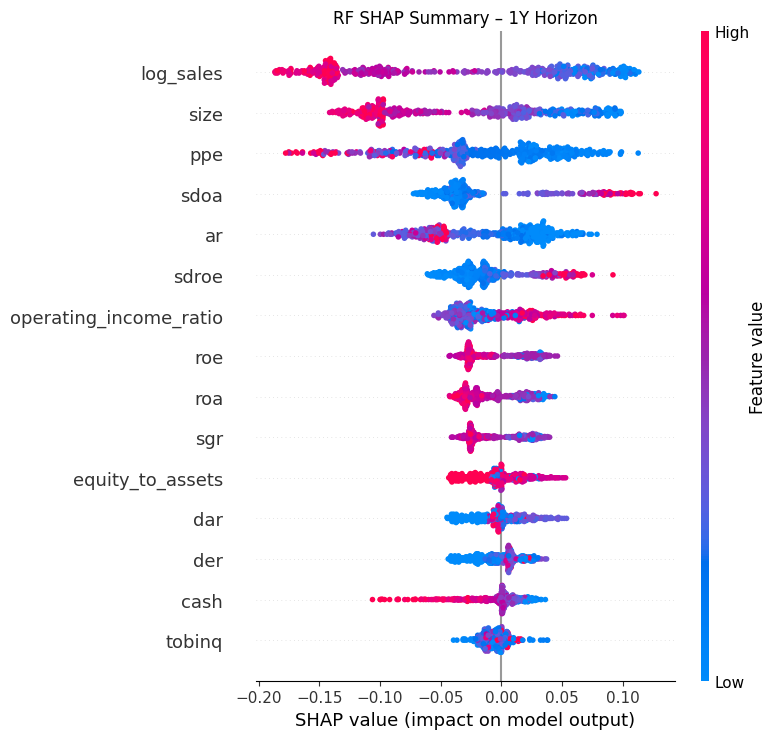


=== TEST 2Y (thr=0.4) ===
Accuracy: 0.8188405797101449
ROC-AUC : 0.8989502249517961
PR-AUC  : 0.6853153238195633
Confusion matrix:
 [[168  41]
 [  9  58]]
              precision    recall  f1-score   support

           0     0.9492    0.8038    0.8705       209
           1     0.5859    0.8657    0.6988        67

    accuracy                         0.8188       276
   macro avg     0.7675    0.8347    0.7846       276
weighted avg     0.8610    0.8188    0.8288       276

Type I Error : 0.1343
Type II Error: 0.1962
Recall      : 0.8657


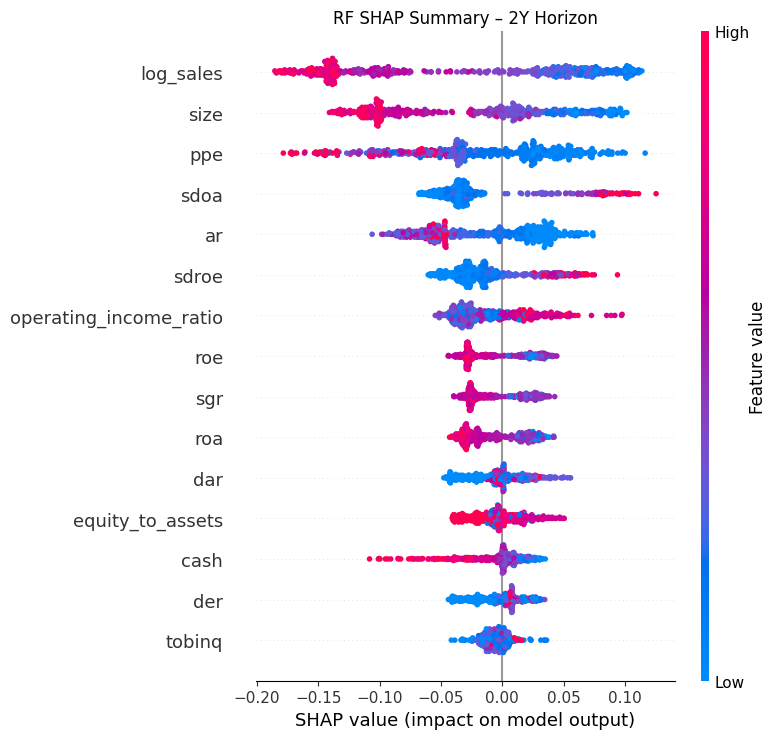


=== TEST 3Y (thr=0.4) ===
Accuracy: 0.8260869565217391
ROC-AUC : 0.8940886699507389
PR-AUC  : 0.6815877177632708
Confusion matrix:
 [[139  35]
 [  5  51]]
              precision    recall  f1-score   support

           0     0.9653    0.7989    0.8742       174
           1     0.5930    0.9107    0.7183        56

    accuracy                         0.8261       230
   macro avg     0.7792    0.8548    0.7963       230
weighted avg     0.8746    0.8261    0.8363       230

Type I Error : 0.0893
Type II Error: 0.2011
Recall      : 0.9107


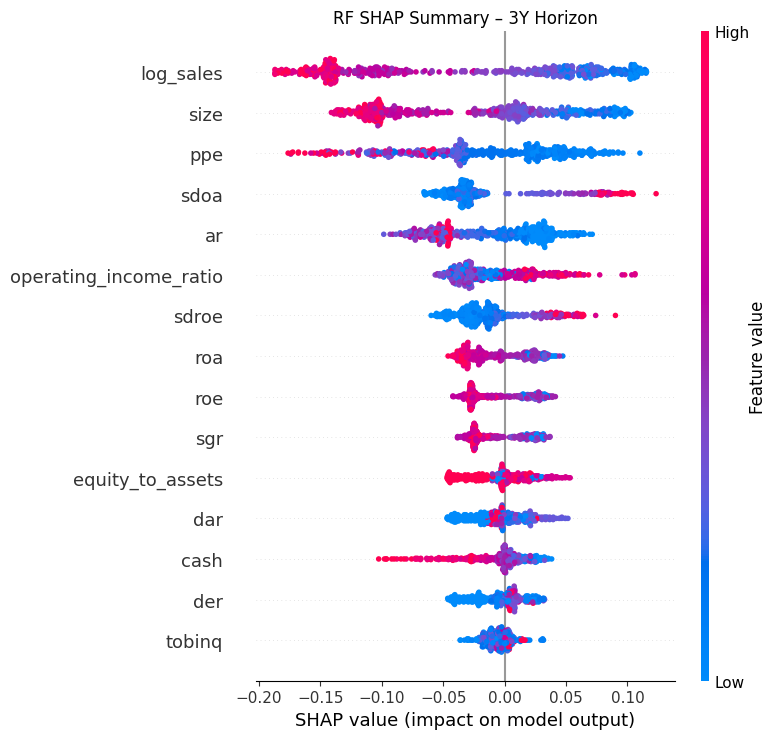


=== TEST 4Y (thr=0.4) ===
Accuracy: 0.8097826086956522
ROC-AUC : 0.9005595523581135
PR-AUC  : 0.7097909578254392
Confusion matrix:
 [[106  33]
 [  2  43]]
              precision    recall  f1-score   support

           0     0.9815    0.7626    0.8583       139
           1     0.5658    0.9556    0.7107        45

    accuracy                         0.8098       184
   macro avg     0.7736    0.8591    0.7845       184
weighted avg     0.8798    0.8098    0.8222       184

Type I Error : 0.0444
Type II Error: 0.2374
Recall      : 0.9556


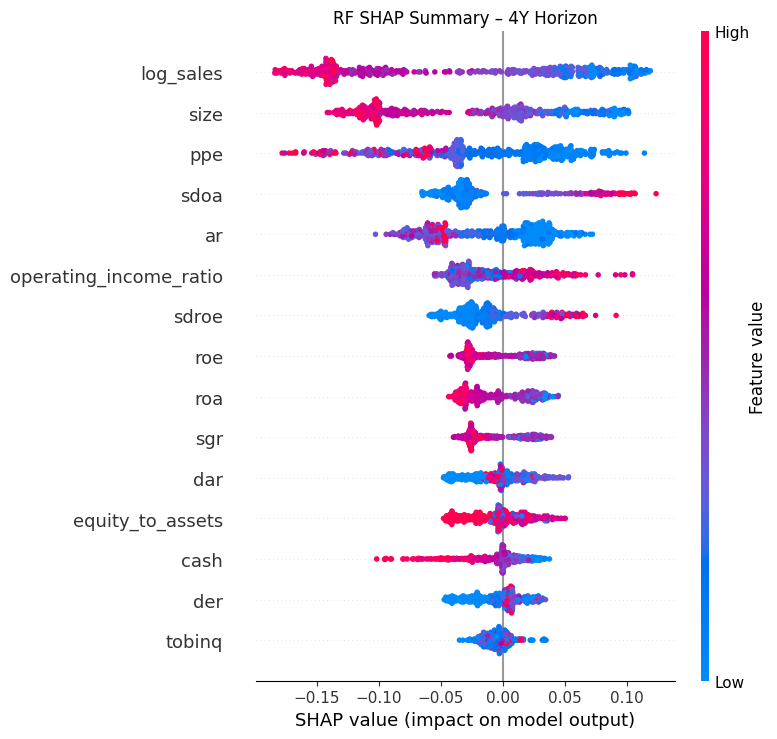


=== TEST 5Y (thr=0.4) ===
Accuracy: 0.7971014492753623
ROC-AUC : 0.8990384615384617
PR-AUC  : 0.7067906625634156
Confusion matrix:
 [[79 25]
 [ 3 31]]
              precision    recall  f1-score   support

           0     0.9634    0.7596    0.8495       104
           1     0.5536    0.9118    0.6889        34

    accuracy                         0.7971       138
   macro avg     0.7585    0.8357    0.7692       138
weighted avg     0.8624    0.7971    0.8099       138

Type I Error : 0.0882
Type II Error: 0.2404
Recall      : 0.9118


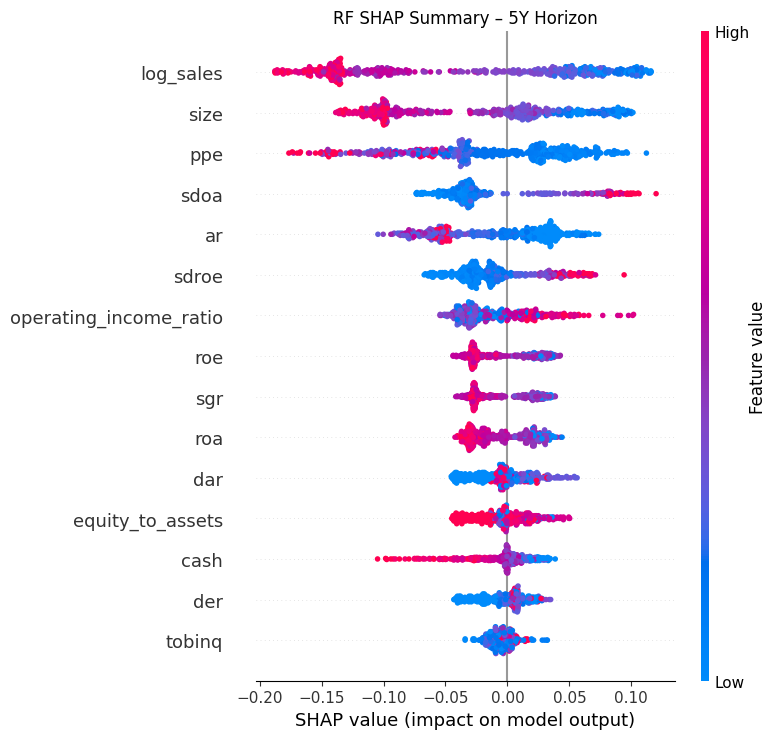

In [14]:
# ============================
# Evaluate and SHAP Plotting
# ============================

for h in [1, 2, 3, 4, 5]:
    # evaluate_rf_model(rf_models[h])

    eval_rf_split(
        name=f"TEST {h}Y",
        rf_model=rf_models[h]["model"],
        X=rf_models[h]["X_test"],
        y=rf_models[h]["y_test"],

        # HARDCODE TUNING TRESHOLD
        # thr=rf_models[h]["threshold"]
        thr=0.4
    )
    
    plot_shap_rf_for_horizon(
        rf_models[h],
        feature_cols=feature_cols
    )

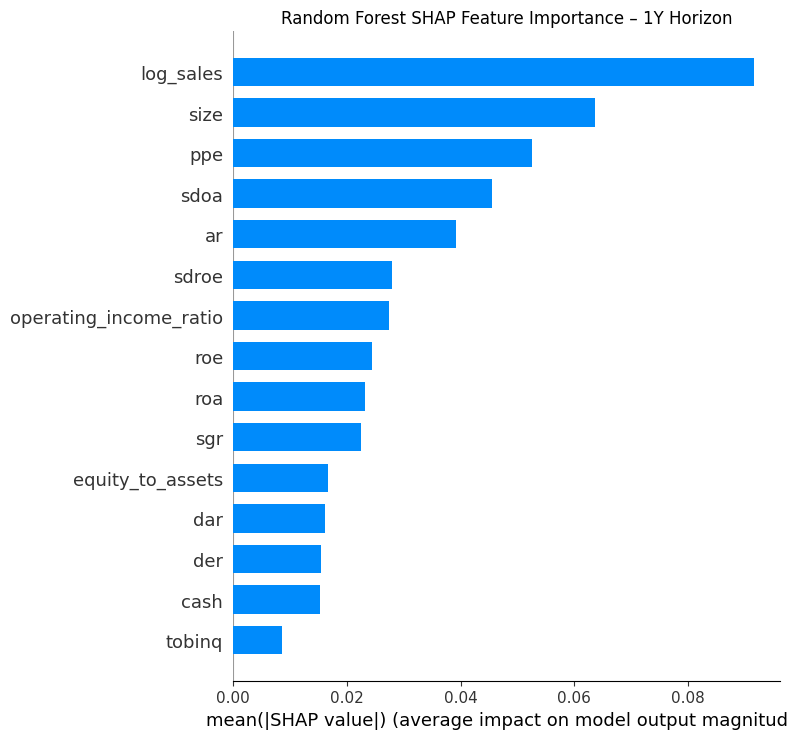

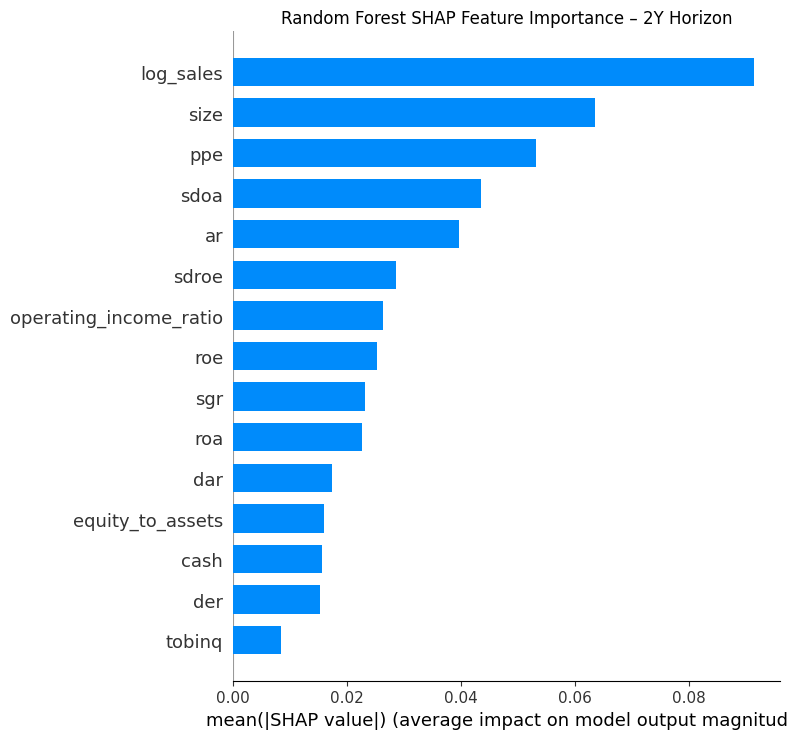

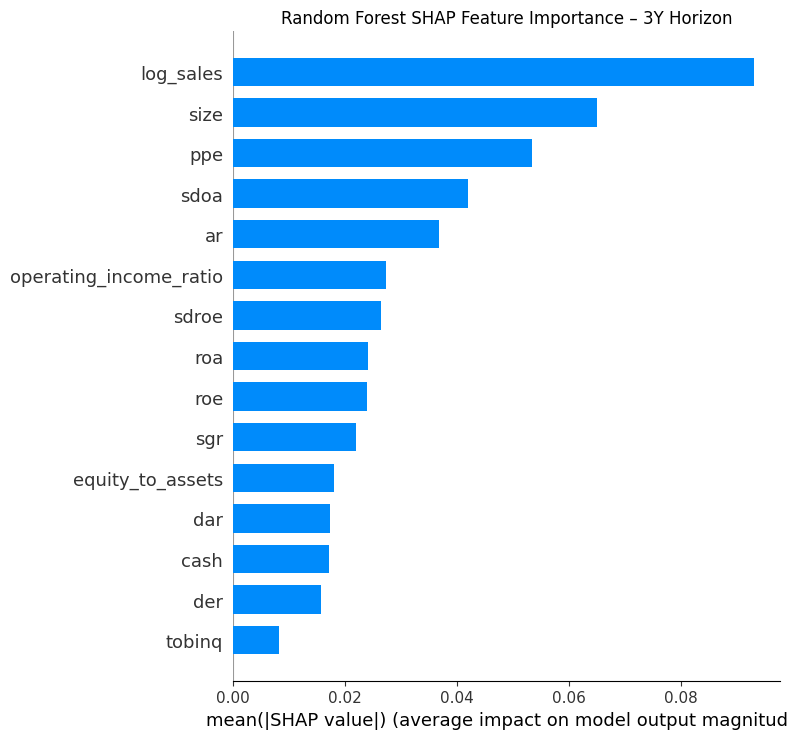

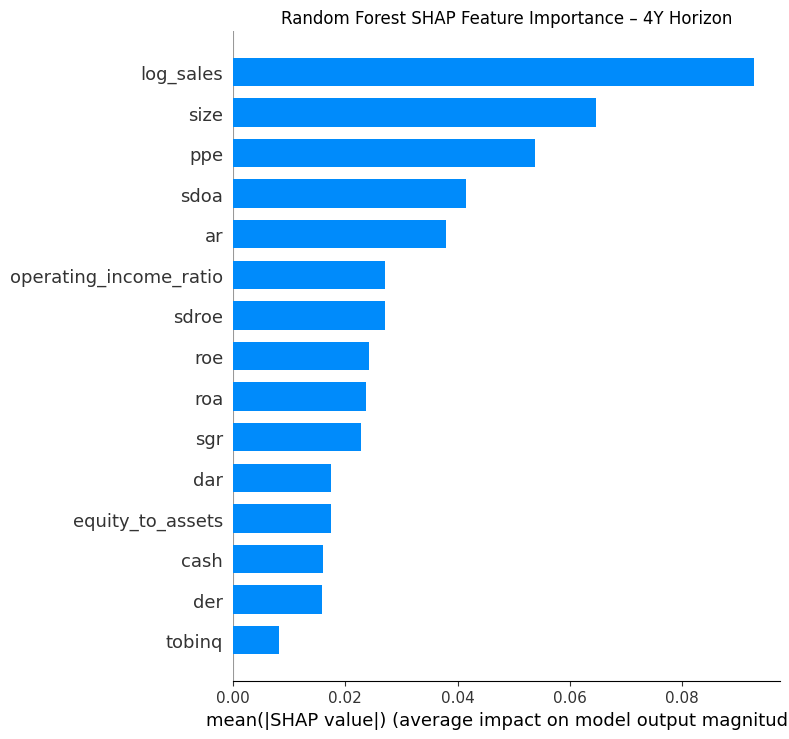

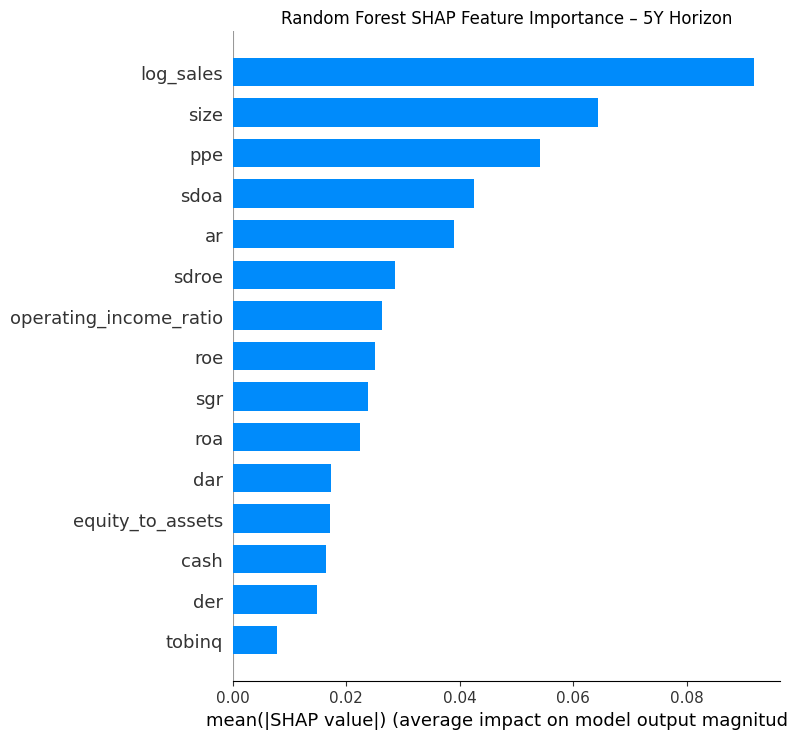

In [15]:
def plot_shap_feature_importance(
    model_dict,
    feature_cols,
    model_type="xgb",
    sample_n=500
):
    X_train = model_dict["X_train"]
    horizon = model_dict["horizon"]

    X_shap = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    if model_type == "xgb":
        import xgboost as xgb
        
        booster = model_dict["booster"]
        dshap = xgb.DMatrix(X_shap)

        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(dshap)

        title = f"XGBoost SHAP Feature Importance – {horizon}Y Horizon"

    elif model_type == "rf":
        rf = model_dict["model"]
        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(X_shap)[1]  # class 1

        title = f"Random Forest SHAP Feature Importance – {horizon}Y Horizon"

    else:
        raise ValueError("model_type must be 'xgb' or 'rf'")

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_shap,
        feature_names=feature_cols,
        plot_type="bar",
        show=False
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


for h in [1, 2, 3, 4, 5]:
    plot_shap_feature_importance(rf_models[h], feature_cols, model_type="rf")


SHAP Dependence – RF 1Y Horizon


<Figure size 600x400 with 0 Axes>

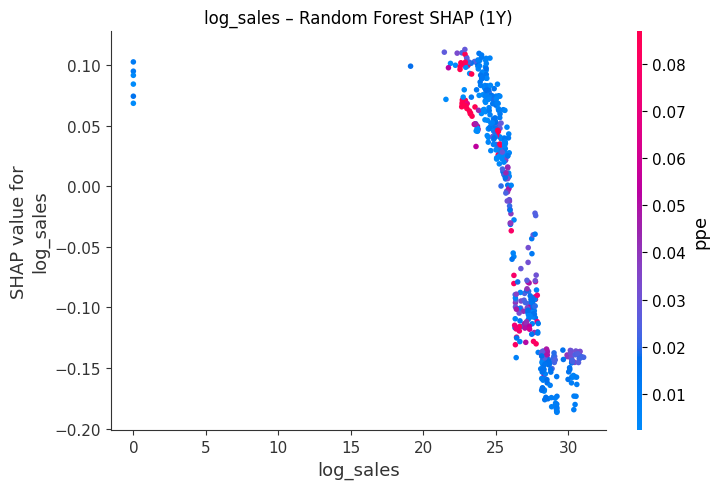

<Figure size 600x400 with 0 Axes>

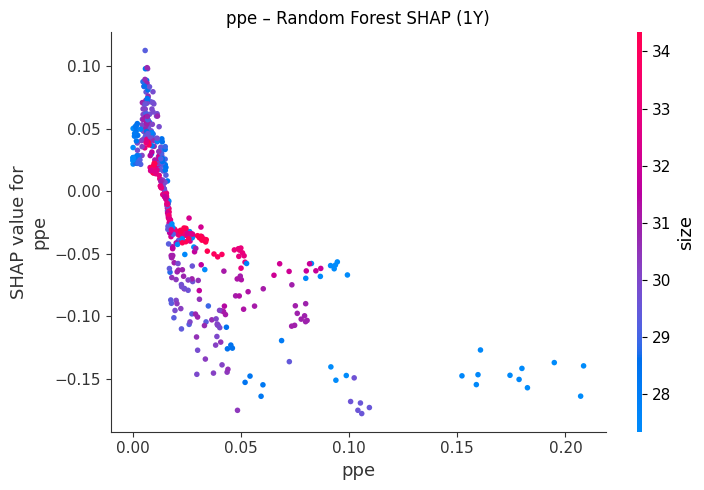

<Figure size 600x400 with 0 Axes>

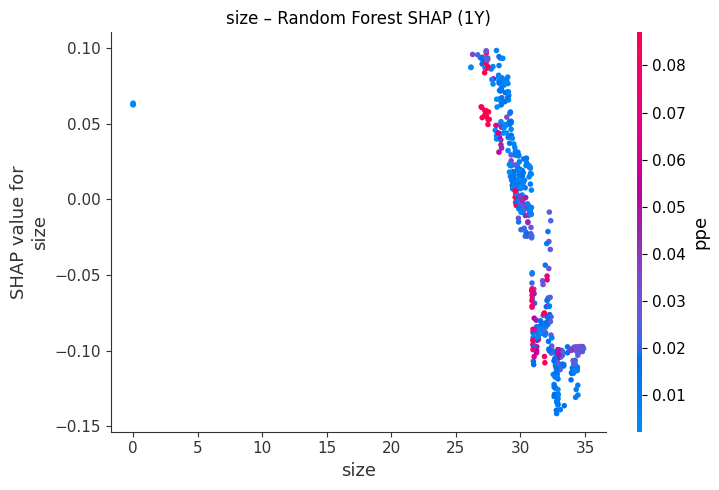

<Figure size 600x400 with 0 Axes>

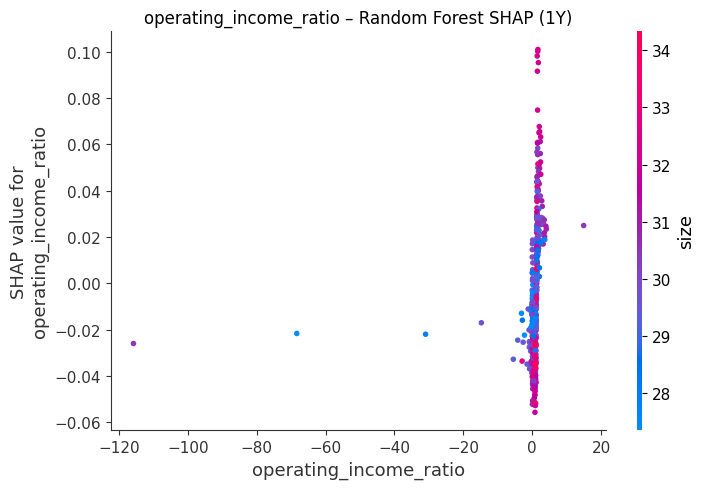

<Figure size 600x400 with 0 Axes>

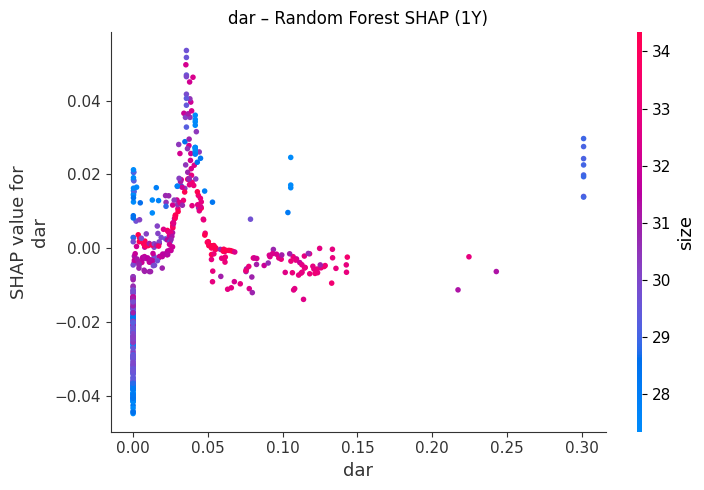

<Figure size 600x400 with 0 Axes>

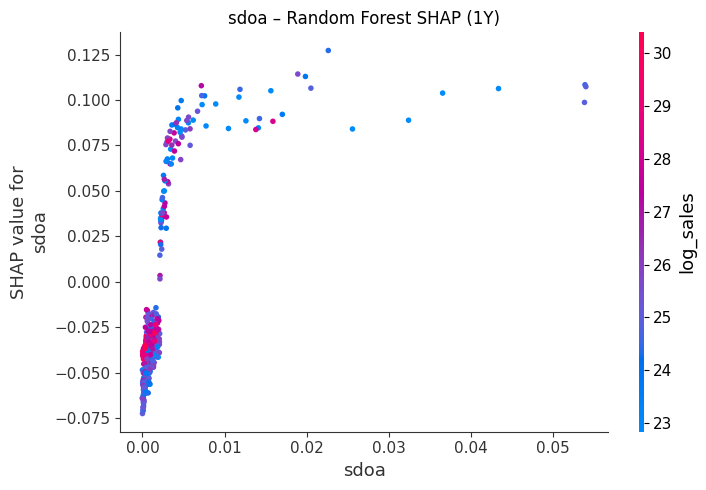


SHAP Dependence – RF 2Y Horizon


<Figure size 600x400 with 0 Axes>

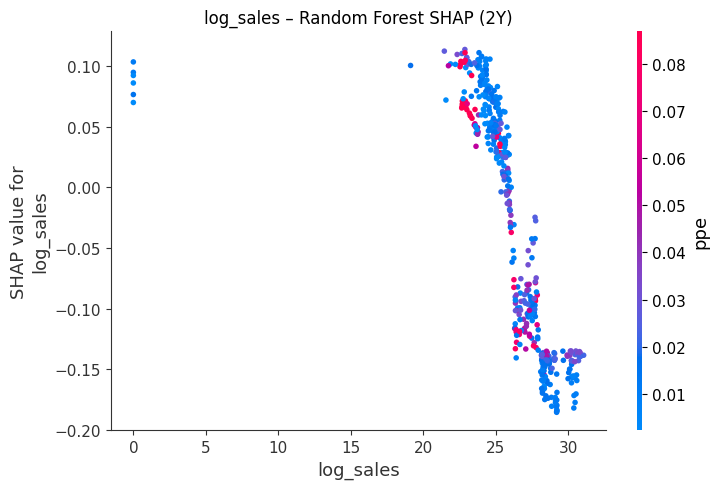

<Figure size 600x400 with 0 Axes>

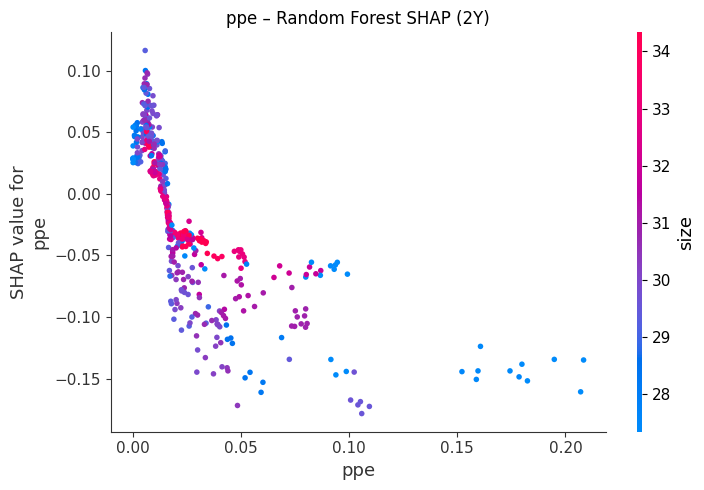

<Figure size 600x400 with 0 Axes>

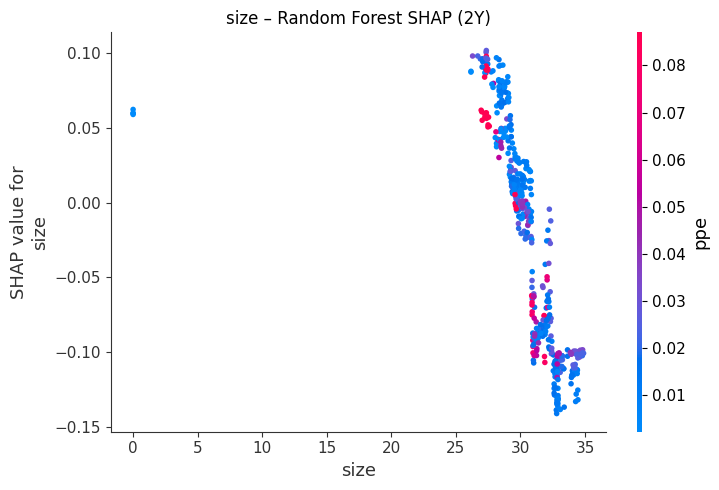

<Figure size 600x400 with 0 Axes>

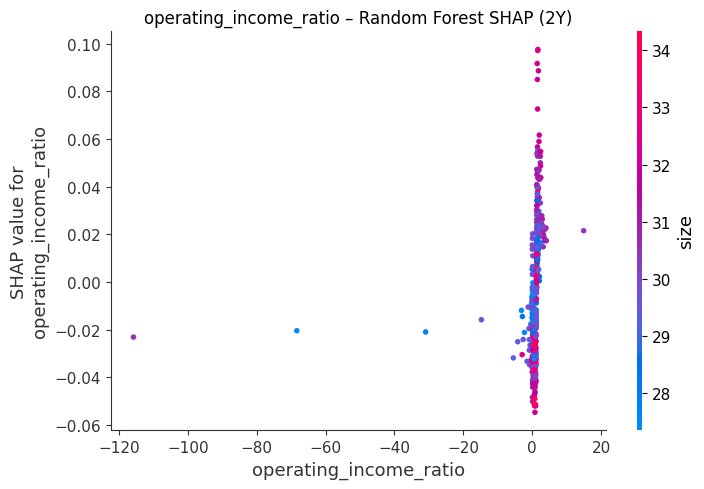

<Figure size 600x400 with 0 Axes>

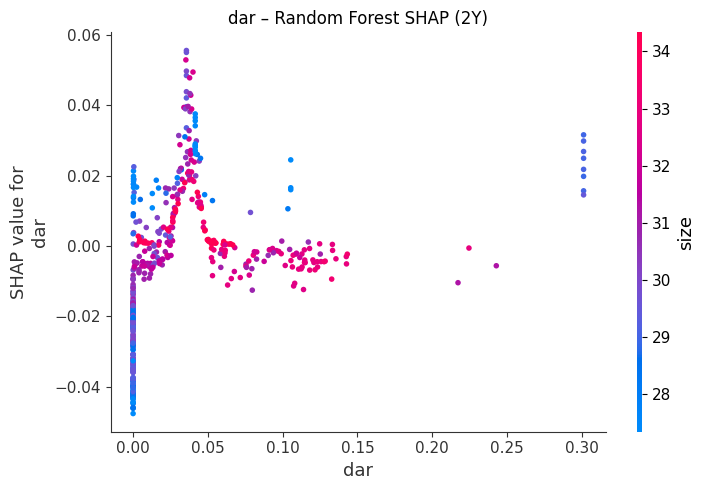

<Figure size 600x400 with 0 Axes>

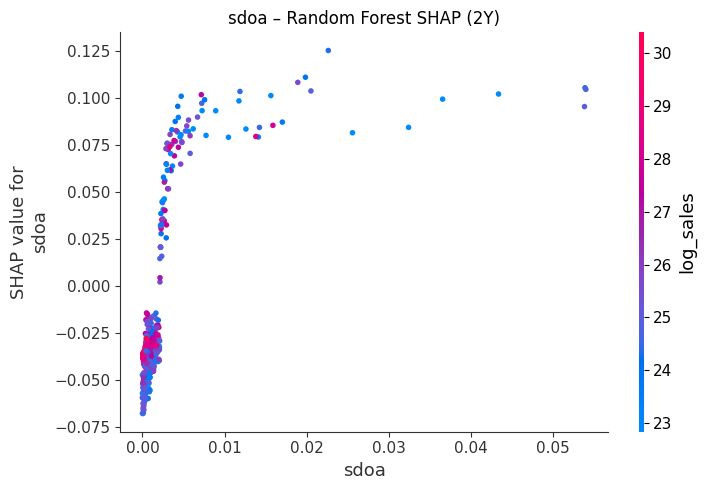


SHAP Dependence – RF 3Y Horizon


<Figure size 600x400 with 0 Axes>

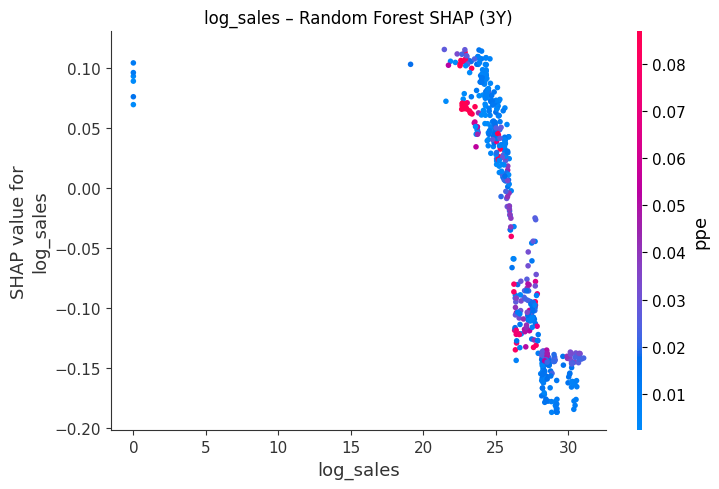

<Figure size 600x400 with 0 Axes>

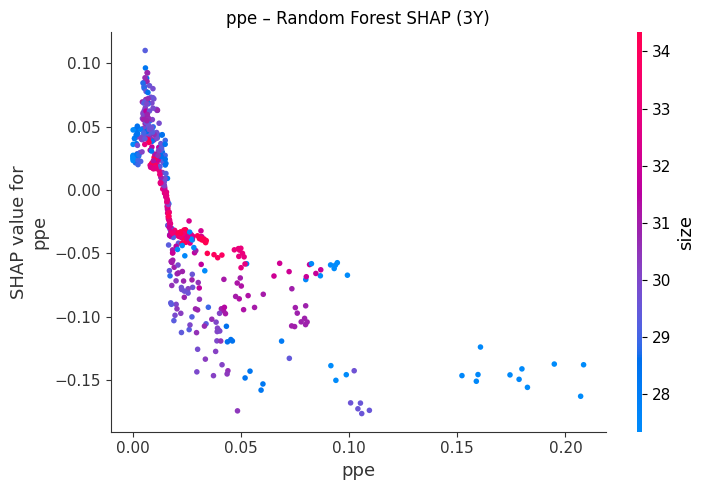

<Figure size 600x400 with 0 Axes>

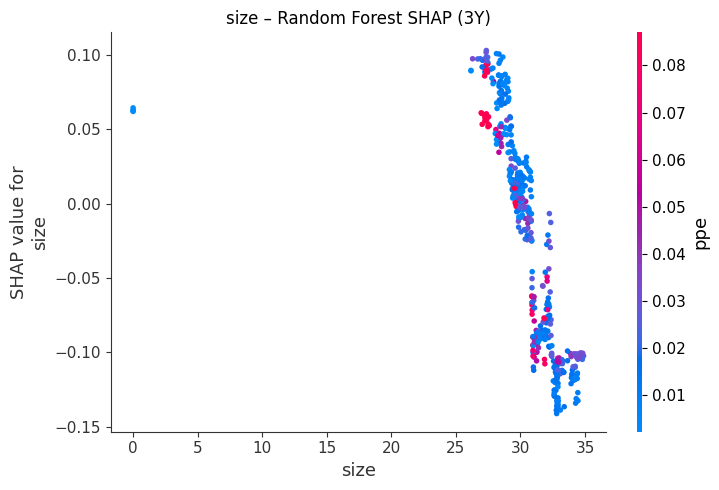

<Figure size 600x400 with 0 Axes>

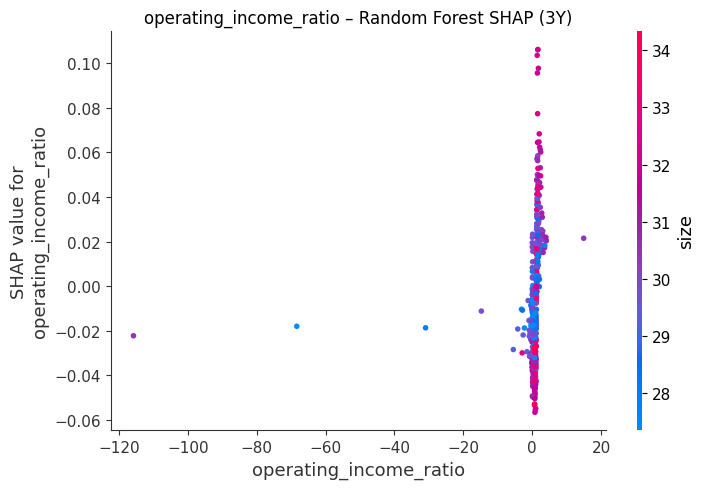

<Figure size 600x400 with 0 Axes>

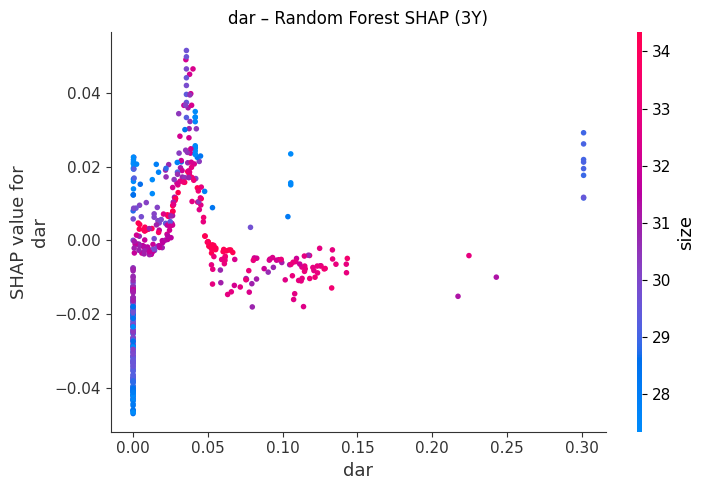

<Figure size 600x400 with 0 Axes>

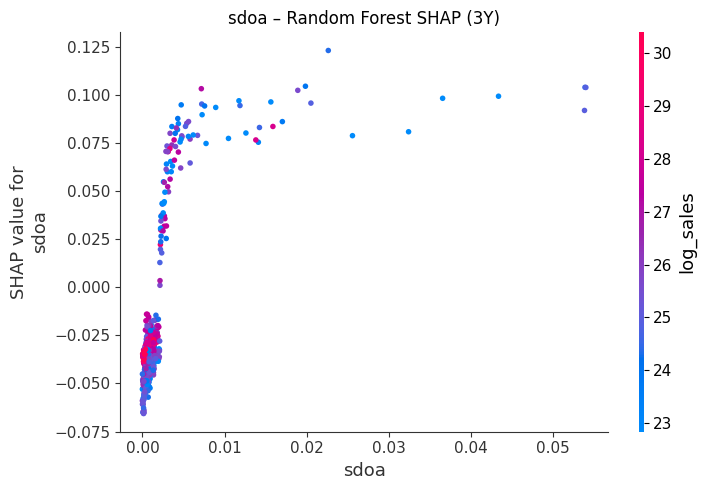


SHAP Dependence – RF 4Y Horizon


<Figure size 600x400 with 0 Axes>

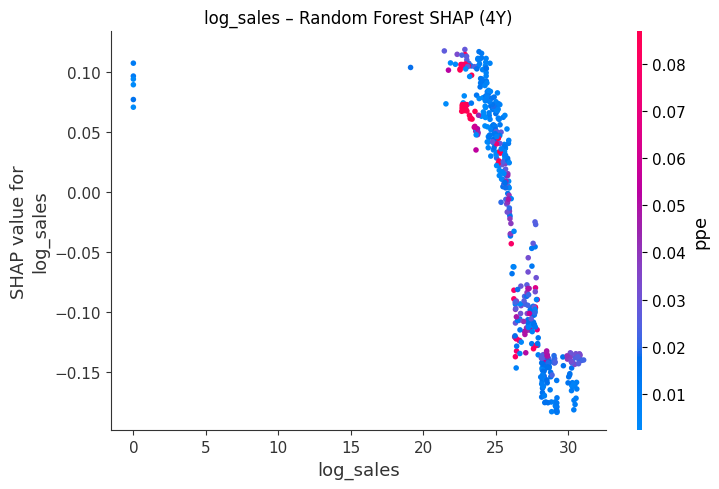

<Figure size 600x400 with 0 Axes>

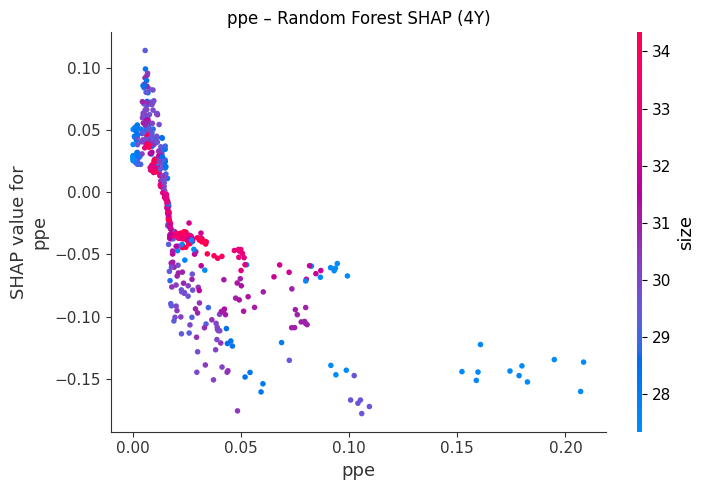

<Figure size 600x400 with 0 Axes>

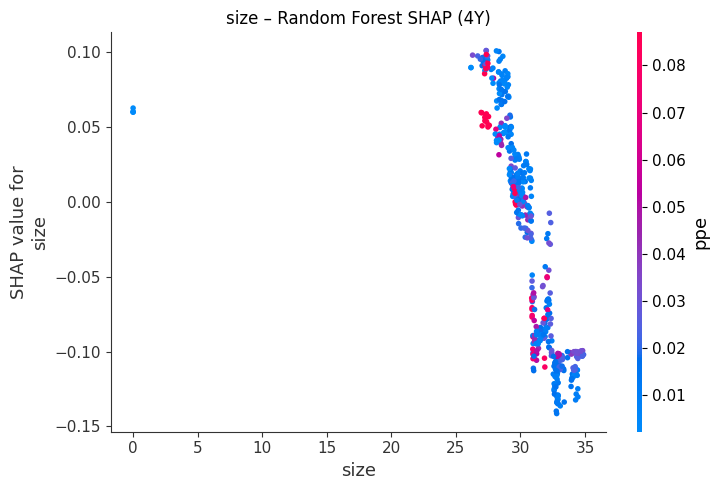

<Figure size 600x400 with 0 Axes>

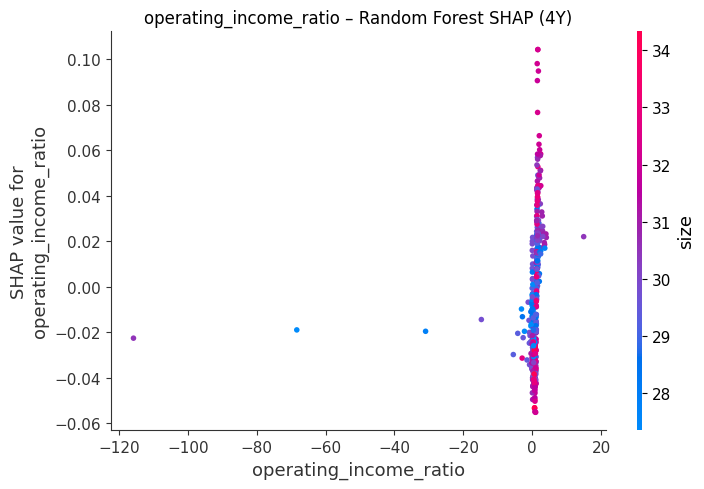

<Figure size 600x400 with 0 Axes>

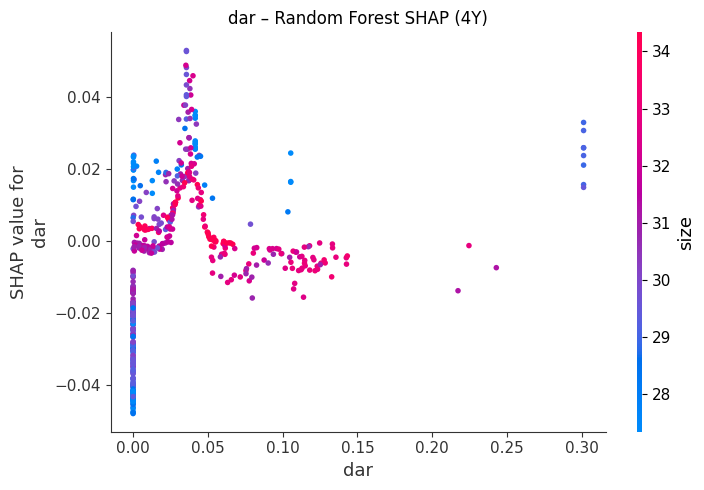

<Figure size 600x400 with 0 Axes>

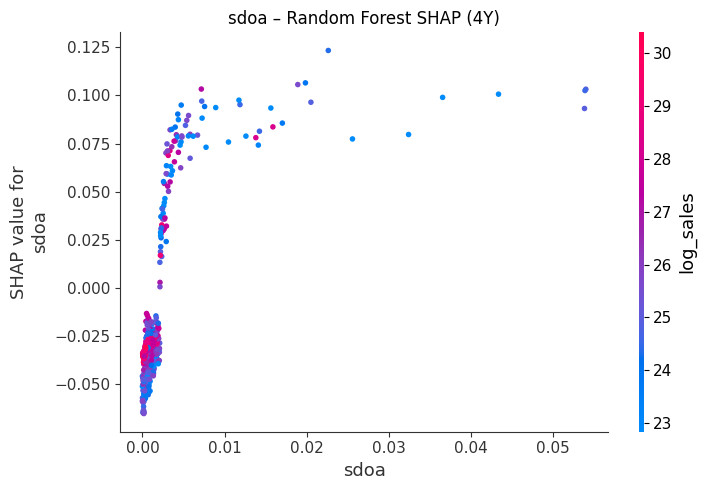


SHAP Dependence – RF 5Y Horizon


<Figure size 600x400 with 0 Axes>

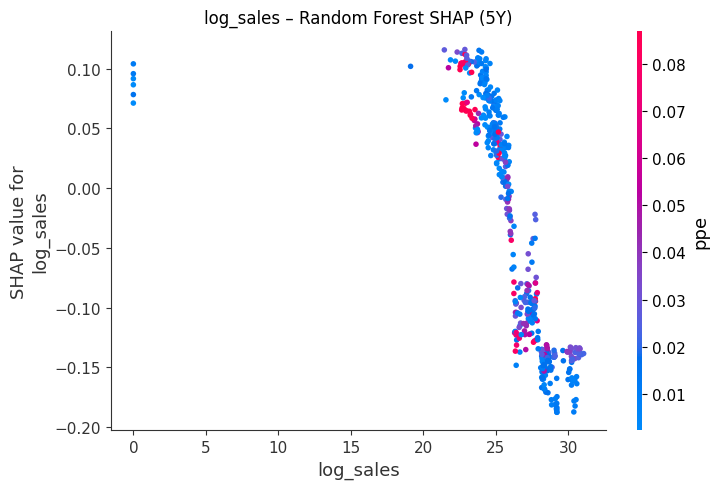

<Figure size 600x400 with 0 Axes>

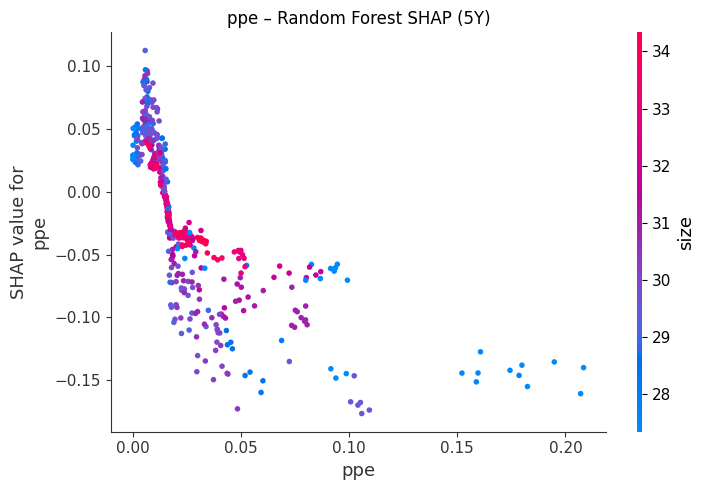

<Figure size 600x400 with 0 Axes>

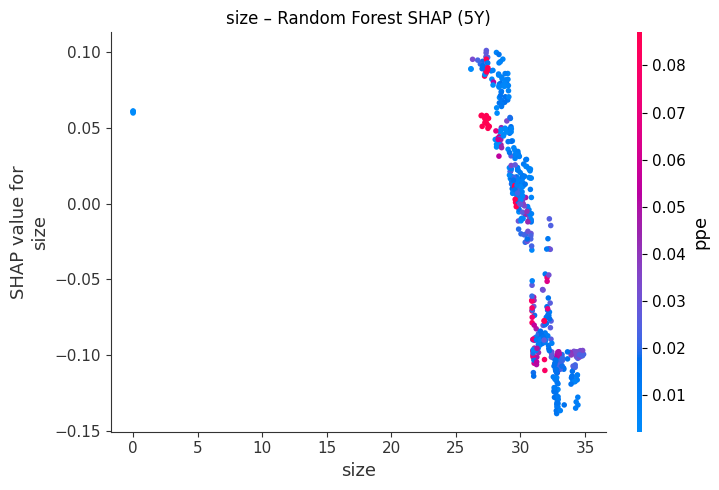

<Figure size 600x400 with 0 Axes>

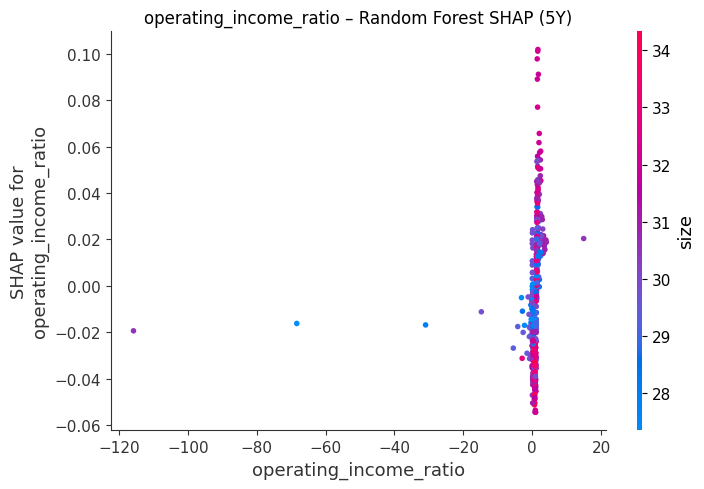

<Figure size 600x400 with 0 Axes>

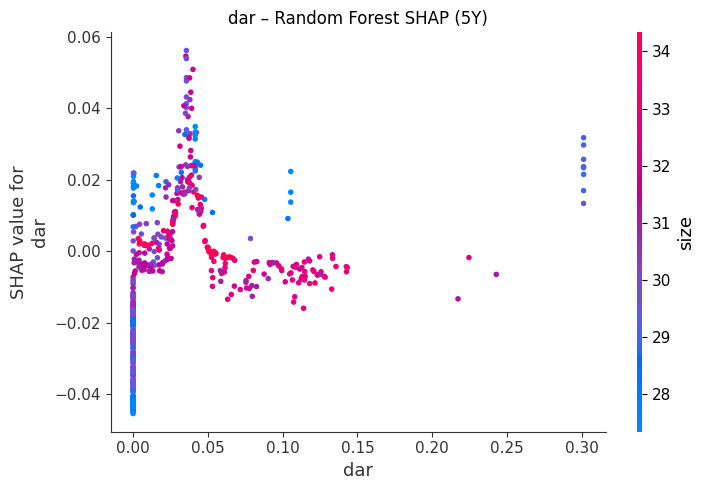

<Figure size 600x400 with 0 Axes>

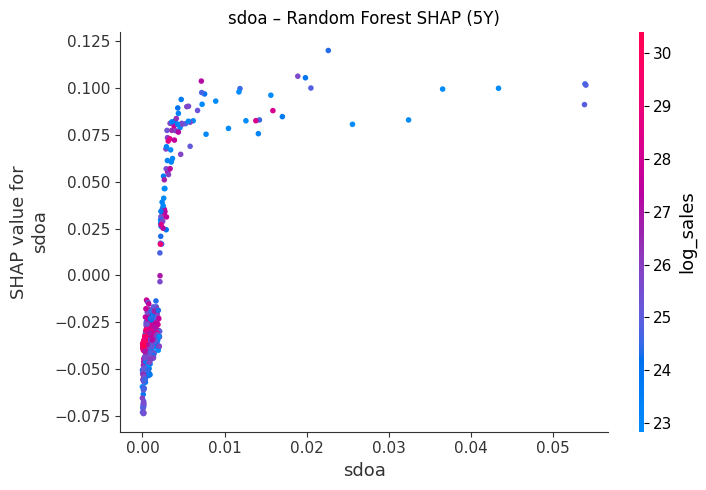

In [17]:
# ============================
# SHAP Dependence Plot (Per Horizon)
# ============================

import shap
import xgboost as xgb
import matplotlib.pyplot as plt

top_features = [
    "log_sales",
    "ppe",
    "size",
    "operating_income_ratio",
    "dar",
    "sdoa",
]

def plot_shap_dependence(
    model_dict,
    top_features,
    model_type="xgb",      # "xgb" atau "rf"
    sample_n=500
):
    """
    SHAP dependence plot for XGBoost or Random Forest (per horizon)

    model_dict : dict
        Output dari train_xgb_for_horizon() atau train_rf_for_horizon()
    model_type : str
        "xgb" or "rf"
    """

    horizon = model_dict["horizon"]
    X_train = model_dict["X_train"]

    print(f"\nSHAP Dependence – {model_type.upper()} {horizon}Y Horizon")

    # ============================
    # Sampling (wajib untuk RF)
    # ============================
    X_shap = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    # ============================
    # SHAP values
    # ============================
    if model_type == "xgb":
        booster = model_dict["booster"]
        dshap = xgb.DMatrix(X_shap)

        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(dshap)

        title_prefix = "XGBoost"

    elif model_type == "rf":
        rf = model_dict["model"]

        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(X_shap)[1]  # class = distress

        title_prefix = "Random Forest"

    else:
        raise ValueError("model_type must be 'xgb' or 'rf'")

    # ============================
    # Dependence plots
    # ============================
    for feat in top_features:
        if feat not in X_shap.columns:
            continue

        plt.figure(figsize=(6, 4))
        shap.dependence_plot(
            feat,
            shap_values,
            X_shap,
            show=False
        )
        plt.title(f"{feat} – {title_prefix} SHAP ({horizon}Y)")
        plt.tight_layout()
        plt.show()


for h in [1, 2, 3, 4, 5]:
    plot_shap_dependence(
        model_dict=rf_models[h],
        top_features=top_features,
        model_type="rf"
    )